In [24]:
from matplotlib import pyplot as plt
import math, os, re, time, random, string
import numpy as np, pandas as pd, seaborn as sns
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from collections import defaultdict
import wordcloud

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import *

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from tensorflow.keras.layers import *
from tensorflow.keras import Input, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow_addons as tfa

from transformers import TFAutoModel, AutoTokenizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tau\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [33]:
df = pd.read_csv('./raw_data/reddit_train.csv', encoding='latin-1')
test = pd.read_csv('./raw_data/reddit_test.csv', encoding='latin-1')

In [34]:
train, val = train_test_split(df, test_size=0.7)
train.shape
val.shape
test.shape

(6400, 4)

(14936, 4)

(7111, 4)

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6400 entries, 9334 to 1502
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6400 non-null   int64 
 1   X           6400 non-null   int64 
 2   BODY        6400 non-null   object
 3   REMOVED     6400 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 250.0+ KB


In [36]:
def features(df):
    df['word count'] = df['BODY'].apply(lambda x: len(x.split())) #count number of words in text
    df['unique word count'] = df['BODY'].apply(lambda x: len(set(x.split()))) #count unique words
    df['char count'] = df['BODY'].apply(lambda x: len(x)) #count number of characters
    df['url count'] = df['BODY'].apply(lambda x: len([i for i in str(x) if i == 'http'])) #count number of urls
    df['stopword count'] = df['BODY'].apply(lambda x: len([i for i in x.lower().split() if i in wordcloud.STOPWORDS]))
    df['punctuation count'] = df['BODY'].apply(lambda x: len([i for i in str(x) if i in string.punctuation]))
    
features(train)
features(test)
features(val)

In [37]:
y_train = train['REMOVED']
y_val = val['REMOVED']
y_test = test['REMOVED']

### Tokenize

In [38]:
train_text = [i for i in train['BODY']]
test_text = [i for i in test['BODY']]
val_text = [i for i in val['BODY']]

In [39]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(train_text)

print(len(tokenizer.word_index), 'unique tokens')

train_seq = tokenizer.texts_to_sequences(train_text)
test_seq = tokenizer.texts_to_sequences(test_text)
val_seq = tokenizer.texts_to_sequences(val_text)

22957 unique tokens


In [40]:
train_data = pad_sequences(train_seq, 200)
val_data = pad_sequences(val_seq, 200)
test_data = pad_sequences(test_seq, 200)

In [41]:
train_data.shape
val_data.shape
test_data.shape

(6400, 200)

(14936, 200)

(7111, 200)

### meta feature scaling

In [42]:
scaler = StandardScaler()
scaler.fit(train.iloc[:, 4:])

train_meta = scaler.transform(train.iloc[:, 4:])
val_meta = scaler.transform(val.iloc[:, 4:])
test_meta = scaler.transform(test.iloc[:, 4:])

StandardScaler()

In [43]:
train_meta.shape
val_meta.shape
test_meta.shape

(6400, 6)

(14936, 6)

(7111, 6)

### modeling functions

In [44]:
def loss_acc_plot(history):
    scores = pd.DataFrame(history.history)
    scores[['loss', 'val_loss']].plot();
    scores[['accuracy', 'val_accuracy']].plot();

def test_model(model):
    y_pred = (model.predict([test_data, test_meta]) > 0.5).astype(int)
    print('\nf1 score is:', f1_score(y_test, y_pred, average='macro'))
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', 
                              factor = 0.5, 
                              verbose = 1, 
                              patience = 4,                        
                              min_lr = 0.0001)   
    
def model_process(model, n_epochs=20):
    model.summary()
    
    history = model.fit(x=[train_data, train_meta],
                        y=y_train,
                        epochs = n_epochs,
                        verbose=1,
                        callbacks=[reduce_lr],
                        validation_data = ([val_data, val_meta], y_val)
                       )
    
    loss_acc_plot(history)
    test_model(model)

In [45]:
embeddings_index = {}
with open('glove.6B.200d.txt','r', encoding="utf8") as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()

400001it [00:20, 19778.33it/s]


In [46]:
EMBEDDING_DIM = 200  
word_index = tokenizer.word_index

#initialize embedding matrix with zeros
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

#add glove word encodings to our library
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        
        #words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
print("Our embedded matrix is of dimension", embedding_matrix.shape)

100%|██████████| 22957/22957 [00:00<00:00, 458718.28it/s]

Our embedded matrix is of dimension (22958, 200)


In [47]:
embedding = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [embedding_matrix],
                     input_length = 200, trainable = False)  

In [48]:
def glove_model():
            
    #define inputs
    nlp_input = Input(shape = (200,), name = 'nlp_input')
    meta_input_train = Input(shape = (6, ), name = 'meta_train')
    
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(0.2)(emb)

    nlp_out = Bidirectional(LSTM(100, 
                                 dropout=0.2, kernel_initializer = 'orthogonal',
                                 ))(emb)     
     
    #add meta data    
    x = Concatenate()([nlp_out, meta_input_train])
    
    #add second hidden layer
    x = Dropout(0.2)(x)
    x = (Dense(100, 
               activation = 'relu'
              ))(x)
    
    #add output layer
    x = Dropout(0.4)(x)
    preds = Dense(1, 
                  activation='sigmoid'
                 )(x)
    
    #compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)
    model.compile(loss = 'binary_crossentropy', optimizer = Adam(0.004), metrics = ['accuracy'])
    
    return model

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 nlp_input (InputLayer)         [(None, 200)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 200, 200)     4591600     ['nlp_input[0][0]']              
                                                                                                  
 spatial_dropout1d_3 (SpatialDr  (None, 200, 200)    0           ['embedding_3[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 200)         240800      ['spatial_dropout1d_3[0][0]

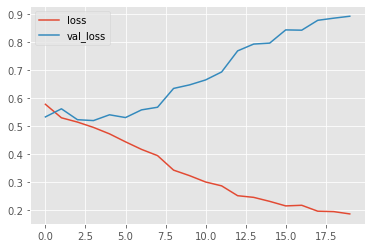

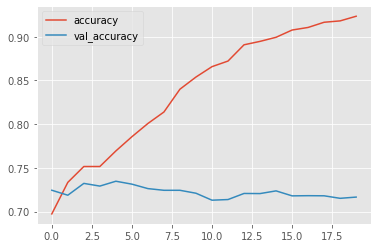

In [49]:
model = glove_model()
model_process(model, n_epochs=20)

### additional preprocessing

In [30]:
def clean_text(text):
    '''Make text lowercase, remove text in square bracketsremove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

stop_words = stopwords.words('english')+['u', 'im', 'c']

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text 

stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

def preprocess(df):
    df = df.apply(clean_text)
    df = df.apply(remove_stopwords)
    df = df.apply(stemm_text)
    return df

In [31]:
train['BODY'] = preprocess(train['BODY'])
val['BODY'] = preprocess(val['BODY'])
test['BODY'] = preprocess(test['BODY'])

17771 unique tokens


StandardScaler()

100%|██████████| 17771/17771 [00:00<00:00, 771947.93it/s]


Our embedded matrix is of dimension (17772, 200)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 nlp_input (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 100, 200)     3554400     ['nlp_input[0][0]']              
                                                                                                  
 spatial_dropout1d_2 (SpatialDr  (None, 100, 200)    0           ['embedding_2[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 200

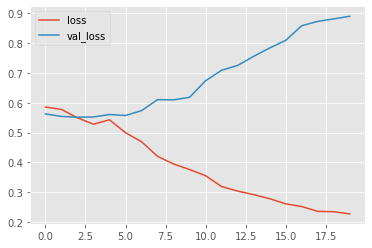

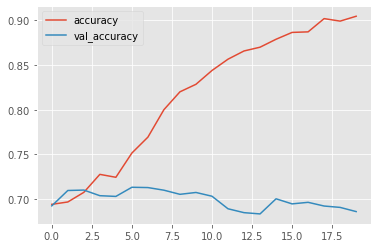

In [32]:
train_text = [i for i in train['BODY']]
test_text = [i for i in test['BODY']]
val_text = [i for i in val['BODY']]

tokenizer = Tokenizer()

tokenizer.fit_on_texts(train_text)

print(len(tokenizer.word_index), 'unique tokens')

train_seq = tokenizer.texts_to_sequences(train_text)
test_seq = tokenizer.texts_to_sequences(test_text)
val_seq = tokenizer.texts_to_sequences(val_text)

train_data = pad_sequences(train_seq, 100)
val_data = pad_sequences(val_seq, 100)
test_data = pad_sequences(test_seq, 100)

scaler = StandardScaler()
scaler.fit(train.iloc[:, 4:])

train_meta = scaler.transform(train.iloc[:, 4:])
val_meta = scaler.transform(val.iloc[:, 4:])
test_meta = scaler.transform(test.iloc[:, 4:])


EMBEDDING_DIM = 200  
word_index = tokenizer.word_index

#initialize embedding matrix with zeros
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

#add glove word encodings to our library
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        
        #words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
print("Our embedded matrix is of dimension", embedding_matrix.shape)


embedding = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [embedding_matrix],
                     input_length = 100, trainable = False)  

model = glove_model()
model_process(model, n_epochs=20)